# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении имеется набор фотографий людей с указанием возраста. Значения MAE на тестовой выборке должно быть не больше 8.

**Этапы работы:**
1. Проведение исследовательского анализа набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитать её качество.



## Исследовательский анализ данных

**Примечание.** Я пробовала выполнить эту часть проекта как в JupyterHub, так и в локальной тетради. При локальной работе данные были скачаны с сайта [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/) и преобразованы так, как показано в разделе ниже. В результате, как и при работе в JupyterHub, в нашем распоряжении оказывается одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv`.

### Загрузка и преобразование данных (для локальной работы)

Код ниже выполняется при загрузке данных с сайта [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/) (на данный момент уже загружены). Здесь код приведен в ячейках Markdown для возможности запустить тетрадь как локально, так и в JupyterHub.

Загруженные данные в папке `appa-real-release` разделены на выборки: `train`, `valid` и `test`. Имеется 6 CSV-файлов: `gt_train.csv`, `gt_valid.csv`, `gt_test.csv`, `gt_avg_train.csv`, `gt_avg_valid.csv`, `gt_avg_test.csv`, каждый из которых, помимо прочего, содержит необходимые нам колонки `file_name` и `real_age`. Папки `train`, `valid` и `test` содержат по три файла на каждое изображение: `.jpg`, `.jpg_face.jpg` и `jpg.mat`. Необходимо объединить все изображения `.jpg_face.jpg` в одну папку и переименовать их.

Импортируем необходимые модули.

```python
import os
import shutil
from glob import glob
import pandas as pd
```

Создадим CSV-файл `labels.csv` с двумя столбцами: `file_name` и `real_age`.

Создадим объекты pd.DataFrame с двумя столбцами для всех трех выборок. Объединим датафреймы, результат сохраним в `labels.csv`.

```python
def csv_read(sample):
    labels_sample = pd.read_csv('appa-real-release/gt_avg_' + sample + '.csv',
                                usecols = ['file_name', 'real_age'])
    return labels_sample
```

```python
labels_train = csv_read('train')
labels_valid = csv_read('valid')
labels_test = csv_read('test')

labels = pd.concat([labels_train, labels_valid, labels_test]).reset_index(drop=True)

labels.to_csv('labels.csv')
```

Создадим папку `/final_files`, в которую скопируем все файлы изображений, содержащие в названии `jpg_face`. Переименуем файлы в новой папке так, чтобы названия совпадали с названиями в столбце `file_name` CSV-файлa `labels.csv`

```python
os.mkdir("final_files")
```

```python
def copy_images(sample):
    for file in glob('/Users/oksana/Downloads/appa-real-release/' + sample + '/*face*'):
        shutil.copy(file, 'final_files')
```

```python
copy_images('train')
copy_images('valid')
copy_images('test')
```

```python
dir = 'final_files/'

for file in os.listdir(dir):
    old_filepath = os.path.join(path, file)
    new_name = file[0:7] + 'jpg'
    new_filepath = os.path.join(dir, new_name)

    os.rename(old_filepath, new_filepath)
```

### Анализ данных

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Доступ к Google Диску

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Сохраним данные CSV-файла в переменной `labels`.

In [3]:
try:
    labels = pd.read_csv('/datasets/faces/labels.csv')
except:
    labels = pd.read_csv('drive/MyDrive/faces/labels.csv', usecols = ['file_name', 'real_age']) #путь к файлу

Выведем на экран информацию о датасете методом `info()` и описательную статистику методом `describe()`.

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Датасет содержит 7591 изображение лиц людей и данные об их возрасте

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Реальный возраст людей на фото в датасете находится в диапазоне от 1 до 100 лет. Средний возраст (среднее арифметическое и медиана) – около 30 лет, межквартильный размах  – диапазон значений между 20 и 40 годами. Эти данные также можно показать на диаграмме размаха.

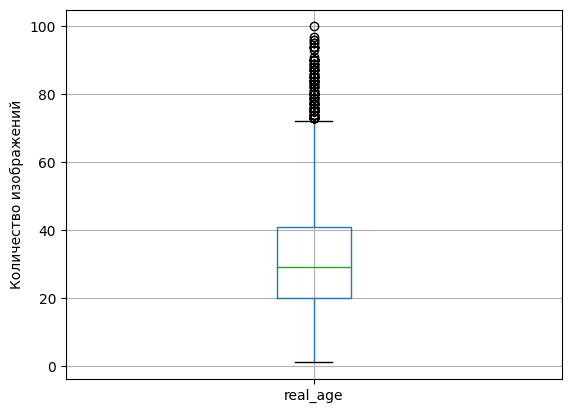

In [6]:
labels.boxplot();
plt.ylabel('Количество изображений');

Построим гистограмму, показывающую распределение возраста в выборке. Зададим `bins=100`, поскольку значения возраста в выборке находятся в диапазоне от 1 до 100 лет.

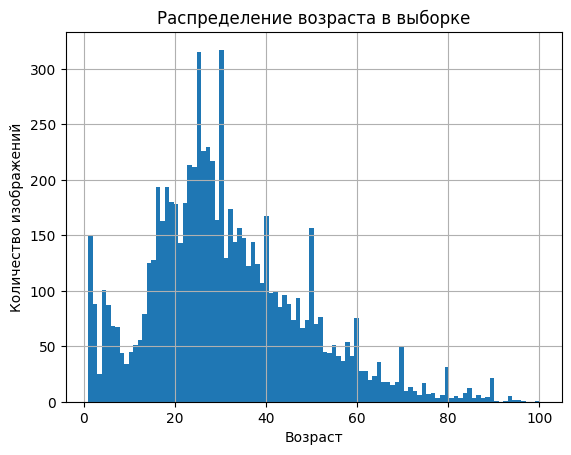

In [7]:
labels.hist(bins=100)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений');

Выведем на экран несколько изображений из датасета. Для этого напишем функцию для для извлечения данных из папки, аргументом которой будет путь к папке.

In [8]:
def load_data(path):
    datagen = ImageDataGenerator(rescale=1./255)
    data_gen_flow = datagen.flow_from_dataframe(
                    dataframe=pd.read_csv(path + 'labels.csv',
                                          usecols = ['file_name', 'real_age']),
                    directory=path + 'final_files/',
                    x_col='file_name',
                    y_col='real_age',
                    target_size=(224, 224),
                    batch_size=32,
                    class_mode='raw',
                    seed=12345)
    return data_gen_flow

In [9]:
try:
    data_gen_flow = load_data('/datasets/faces/')
except:
    data_gen_flow = load_data('drive/MyDrive/faces/') #путь к данным

Found 7591 validated image filenames.


Напечатаем на экране 12 фотографий.

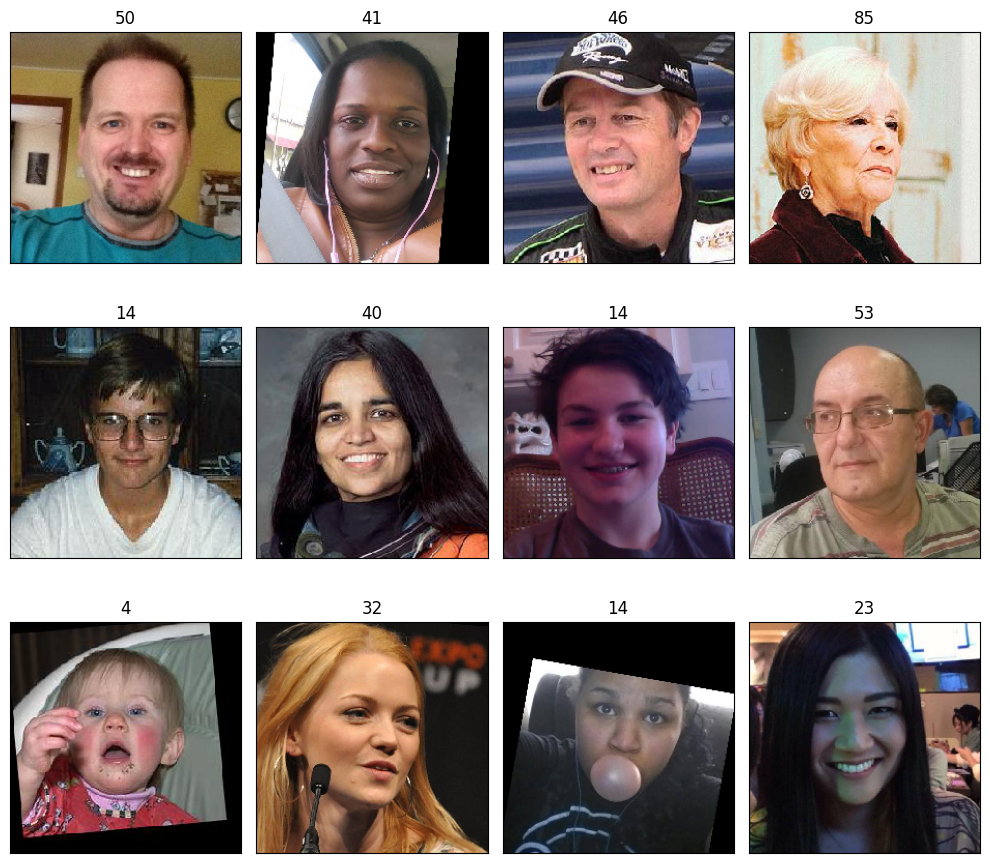

In [10]:
features, target = next(data_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы по шагу 1**
1. Данные загружены и изучены. При работе в локальной тетради данные единожды загружены с сайта [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/) и преобразованы.
2. Размер выборки составляет 7591 изображение.
3. Анализ распределения возраста в выборке, показывает, что среднее значение возраста около 30 лет, межквартильный размах – диапазон значений между 20 и 40 годами. Фотографий с людьми в возрасте старше 80 лет в выборке незначительное количество, а детских фотографий много. Поскольку конечная цель – построить модель, которая по фотографии определит приблизительный возраст покупателя в супермаркете, детские фотографии (особенно в раннем возрасте) могут быть нерелевантны.
4. Выборка содержит фотографии, изображающие лица людей (в отличие от исходных фотографий, фото лиц могут быть неровно обрезаны). На фото также могут присутствовать посторонние предметы (жвачка, микрофон, очки, наушники и т.д), которые могут затруднять определение возраста.

## Обучение модели

**Код обучения модели**

In [11]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255,
                                 horizontal_flip=True)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


**Примечание.** При запуске обучения не в тренажере Практикума код следует дополнить, например, следующими строками (пробовала в Google Colab с GPU, предварительно перенеся папку с фотографиями и CSV-файл на Google Диск в папку `faces` (соответственно, путь: `drive/MyDrive/faces/`), результаты сопоставимы с результатами в тренажере Практикума).

In [12]:
train_data = load_train('drive/MyDrive/faces/') # указать путь к данным
test_data = load_test('drive/MyDrive/faces/')
model = create_model((224, 224, 3))
model_train = train_model(model, train_data, test_data)

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Epoch 1/10
178/178 - 1496s - loss: 234.5221 - mae: 11.0448 - val_loss: 869.9135 - val_mae: 24.6319 - 1496s/epoch - 8s/step
Epoch 2/10
178/178 - 82s - loss: 83.1244 - mae: 6.7976 - val_loss: 591.0975 - val_mae: 19.1577 - 82s/epoch - 460ms/step
Epoch 3/10
178/178 - 82s - loss: 56.3926 - mae: 5.7115 - val_loss: 351.8330 - val_mae: 13.8175 - 82s/epoch - 460ms/step
Epoch 4/10
178/178 - 83s - loss: 39.8455 - mae: 4.8326 - val_loss: 141.3621 - val_mae: 8.8420 - 83s/epoch - 464ms/step
Epoch 5/10
178/178 - 80s - loss: 32.0203 - mae: 4.3372 - val_loss: 140.9181 - val_mae: 9.4843 - 80s/epoch - 451ms/step
Epoch 6/10
178/178 - 85s - loss: 28.7909 - mae: 4.0945 - val_loss: 69.3820 - val_mae: 6.2745 - 85s/epoch - 480ms/step
Epoch 7/10
178/178 - 83s - loss: 24.1666 - mae: 3.7704 - val_loss: 64.2428 - val_mae: 6.0571 - 83s/epoch - 468ms/step
Epoch 8/10
178/178 - 86s - loss: 19.1380 - mae: 3.3718 - val_loss: 62.8501 - val_mae: 5

**Результат вывода модели на экран (из тренажера Практикума)**

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 61s - loss: 223.4113 - mae: 10.6963 - val_loss: 883.4637 - val_mae: 24.8639
Epoch 2/10
178/178 - 44s - loss: 77.3998 - mae: 6.6066 - val_loss: 839.3667 - val_mae: 24.0089
Epoch 3/10
178/178 - 50s - loss: 49.2527 - mae: 5.3423 - val_loss: 217.3306 - val_mae: 10.9081
Epoch 4/10
178/178 - 49s - loss: 34.2253 - mae: 4.4902 - val_loss: 163.5874 - val_mae: 9.5638
Epoch 5/10
178/178 - 44s - loss: 27.9394 - mae: 4.0545 - val_loss: 79.4564 - val_mae: 6.7611
Epoch 6/10
178/178 - 49s - loss: 23.8395 - mae: 3.6945 - val_loss: 72.4936 - val_mae: 6.2959
Epoch 7/10
178/178 - 49s - loss: 18.0530 - mae: 3.2142 - val_loss: 62.0551 - val_mae: 5.8811
Epoch 8/10
178/178 - 43s - loss: 14.1978 - mae: 2.8664 - val_loss: 62.8706 - val_mae: 5.8965
Epoch 9/10
178/178 - 42s - loss: 12.2336 - mae: 2.6646 - val_loss: 67.0002 - val_mae: 6.0833
Epoch 10/10
178/178 - 39s - loss: 10.7648 - mae: 2.5033 - val_loss: 65.3121 - val_mae: 6.1161

60/60 - 10s - loss: 65.3121 - mae: 6.1161
Test MAE: 6.1161

```

**Вывод по шагу 2**

Модель обучена на 10 эпохах и показывет значение MAE на тестовой выборке ниже порогового значения 8.

## Анализ обученной модели

На 10 эпохах удается обучить модель, которая с достаточно высокой точностью (среднее значение ошибки – около 6 лет) позволяет предсказать возраст покупателей. При этом на основании нескольких раундов обучения с разными настройками можно отметить следующее:
* Обучение на различном количестве эпох показывает, что при значении epochs больше 10 качество модели существенно не улучшается: на отдельных эпохах возможны более низкие значения MAE на тестовой выборке (до 5.6), чем наблюдаются на 10 эпохах, но они чередуются со значениями около 6.1-6.3. Около 15 эпохи хначение МАЕ на тренировочной выборке также перестает стабильно снижаться.
* В представленной выше модели применена аугментация обучающей выборки – отражение по горизонтали, применение других опрераций сочтено нецелесообразным: они существенно снижают скорость обучения, при этом фото людей, как правило, ориентированы вертикально, сдвиги также вряд ли могут существенно улучшить качество модели (фотографии в выборке предварительно обработаны и отображают лица, занимающие большую часть изображения).
* Попытка далее снизить learning rate (до `lr=0.00001`) не привела к существенному улучшению качества.
* Модель показала несколько лучший результат при значении `batch_size=32` в функциях `load_train(path)` и `load_test(path)`, чем при значении `batch_size=16`.

Несмотря на то, что качество модели достаточно высокое, и для взрослых покупателей ошибка в 6 лет несущественна, при определении возраста подростков и молодых покупателей эта ошибка может быть критична, поскольку при таком качестве модель с трудом будет справляться со второй задачей фотофиксации: контролировать добросовестность кассиров при продаже алкоголя. Представляется, что результаты обучения для определения возраста молодых покупателей требуют более пристального внимания.

## Итоги

На основании набора фотографий людей с указанием возраста для внедрения системы компьютерного зрения в сетевом супермаркете «Хлеб-Соль»  была построена модель, позволяющая по фотографии определить приблизительный возраст человека. В ходе работы были выполнены следующие действия:

* проведен исследовательский анализ данных: данные загружены (для возможности локальной работы также проведено преобразование данных с сайта [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/)),  рассмотрен разбор выборки и распределение возраста в выборке, на экран были выведены несколько фотографий с обозначением возраста и оценены их особенности и качество;
* данные подготовлены к обучению;
* обучена нейронная сеть архитектуры ResNet (ResNet50) и рассчитано ее качество.

**Общий вывод**:
Модель позволяет предсказать возраст человека с требуемой по условиям задачи точностью. При этом ее погрешности могут быть критичны при определении возраста молодых покупателей супермаркета.